# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Label.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

####**Note: Please use GPU runtime to execute the code efficiently**

## Importing necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import cv2
import seaborn as sns


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer


# Display images using OpenCV
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend
from keras.callbacks import ReduceLROnPlateau
import random


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [2]:
# Mount Google drive to access the dataset
# Run the below code if you using google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
folder_path = "/content/drive/MyDrive/UT AI Course/Module 6 - Computer Vision/Project/"
image_file_name = "images.npy"
csv_file_name = "Labels.csv"

# Load the image file of dataset
images = np.load(folder_path + image_file_name)

# Load the labels file of dataset
labels = pd.read_csv(folder_path + csv_file_name)

In [4]:
labels.head()

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill


## Data Overview

### Understand the shape of the dataset

In [5]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?

    The plants fromthe image below have different leaf sizes, number of leafs and leaf distribution.


2. Is the dataset provided an imbalance? (Check with using bar plots)

    The dataset provided is at a slight inbalance with Shepherds Purse, Common wheat, Maize, and Cleavers having a lower amount of representatoin vs flowers like the Loose Silky-bent, Common Chickweed, Small-flowered Cranesbill, and the Fat Hen.

In [6]:
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

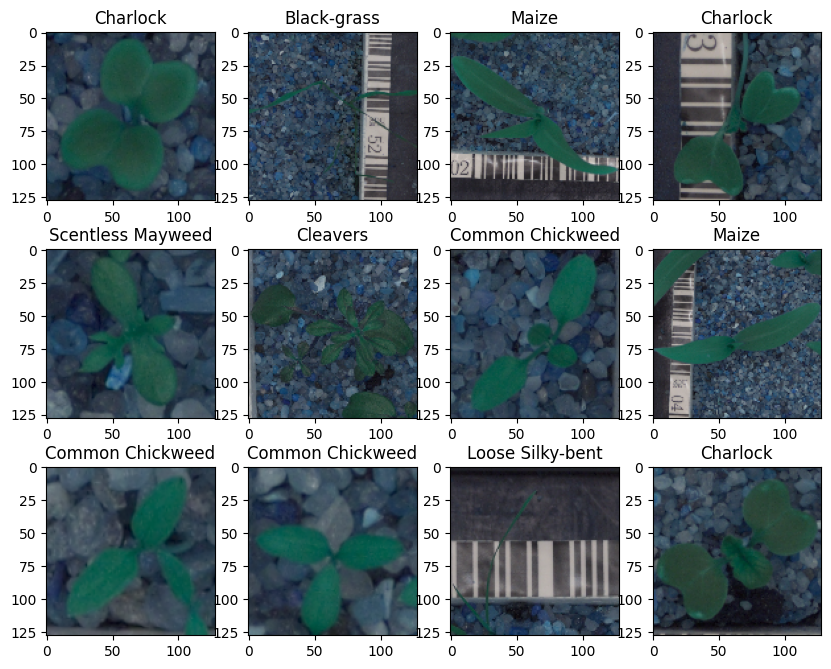

In [7]:
plot_images(images, labels)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Small-flowered Cranesbill'),
  Text(1, 0, 'Fat Hen'),
  Text(2, 0, 'Shepherds Purse'),
  Text(3, 0, 'Common wheat'),
  Text(4, 0, 'Common Chickweed'),
  Text(5, 0, 'Charlock'),
  Text(6, 0, 'Cleavers'),
  Text(7, 0, 'Scentless Mayweed'),
  Text(8, 0, 'Sugar beet'),
  Text(9, 0, 'Maize'),
  Text(10, 0, 'Black-grass'),
  Text(11, 0, 'Loose Silky-bent')])

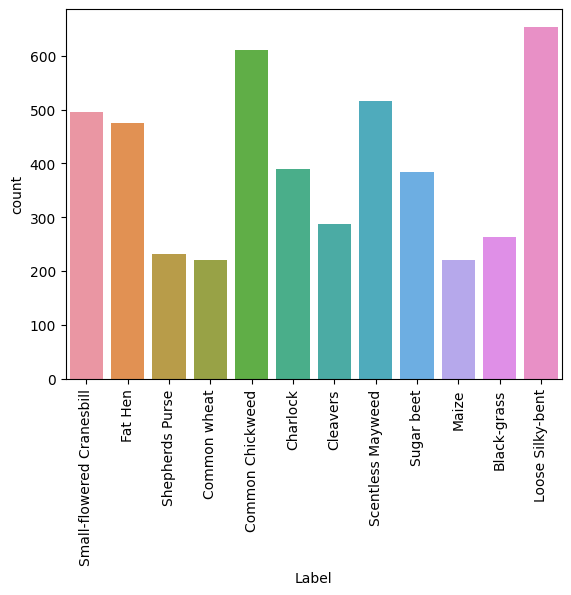

In [8]:
# Target variable distribution:
sns.countplot(x=labels['Label'])
plt.xticks(rotation='vertical')

## Data Pre-Processing

### Convert the BGR images to RGB images.

In [9]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [10]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

**Image before resizing**

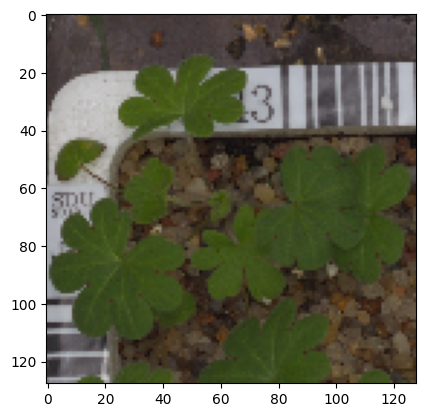

In [11]:
plt.imshow(images[3])

**Image after resizing**

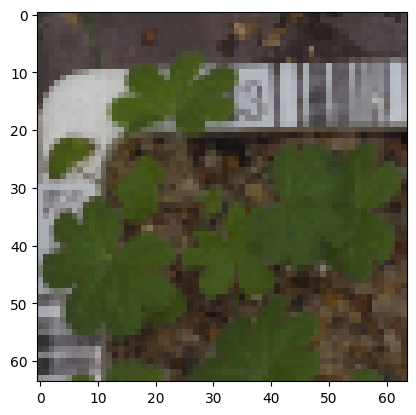

In [12]:
plt.imshow(images_decreased[3])

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [13]:
x_temp, x_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels)
x_train, x_val, y_train, y_val = train_test_split(x_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)

In [14]:
# Corroborate sizes of split:
print(f"Size of train: {x_train.shape}, {y_train.shape}")
print(f"Size of val: {x_val.shape}, {y_val.shape}")
print(f"Size of test: {x_test.shape}, {y_test.shape}")

Size of train: (3847, 64, 64, 3), (3847, 1)
Size of val: (428, 64, 64, 3), (428, 1)
Size of test: (475, 64, 64, 3), (475, 1)


### Encode the target labels

In [15]:
# Convert labels from names to one hot vectors.
# We have already used encoding methods like onehotencoder and labelencoder earlier so now we will be using a new encoding method called labelBinarizer.
# Labelbinarizer works similar to onehotencoder

enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

In [16]:
# Check encoded sizes:
y_train_encoded.shape, y_val_encoded.shape, y_test_encoded.shape

((3847, 12), (428, 12), (475, 12))

### Data Normalization

In [17]:
# Normalizing the image pixels
x_train_normalized = x_train.astype('float32')/255.0
x_val_normalized = x_val.astype('float32')/255.0
x_test_normalized = x_test.astype('float32')/255.0

## Model Building

In [18]:
# Clearing backend and setting seed
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [19]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 128 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

# Adding two similar convolution and max-polling layers with relu activation function
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))


# Flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 16 neurons
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model.add(Dense(12, activation='softmax'))

# Using Adam Optimizer
opt = Adam()

# Compile model with optimizer, categorical_crossentropy as loss function, and prioritizing accuracy.
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        36896     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 32)          0

In [20]:
# Model fitting:
history_1 = model.fit(
            x_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(x_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 13s - loss: 2.4515 - accuracy: 0.1152 - val_loss: 2.4207 - val_accuracy: 0.1846 - 13s/epoch - 107ms/step
Epoch 2/30
121/121 - 1s - loss: 2.3561 - accuracy: 0.1918 - val_loss: 2.1013 - val_accuracy: 0.3411 - 1s/epoch - 9ms/step
Epoch 3/30
121/121 - 1s - loss: 2.0915 - accuracy: 0.2802 - val_loss: 1.8497 - val_accuracy: 0.3808 - 1s/epoch - 8ms/step
Epoch 4/30
121/121 - 1s - loss: 1.9408 - accuracy: 0.3073 - val_loss: 1.7265 - val_accuracy: 0.4182 - 1s/epoch - 8ms/step
Epoch 5/30
121/121 - 1s - loss: 1.8435 - accuracy: 0.3366 - val_loss: 1.7162 - val_accuracy: 0.3972 - 1s/epoch - 9ms/step
Epoch 6/30
121/121 - 1s - loss: 1.7863 - accuracy: 0.3486 - val_loss: 1.5615 - val_accuracy: 0.4486 - 1s/epoch - 9ms/step
Epoch 7/30
121/121 - 1s - loss: 1.7238 - accuracy: 0.3590 - val_loss: 1.5031 - val_accuracy: 0.4696 - 1s/epoch - 10ms/step
Epoch 8/30
121/121 - 1s - loss: 1.6517 - accuracy: 0.3858 - val_loss: 1.3851 - val_accuracy: 0.5070 - 1s/epoch - 9ms/step
Epoch 9/30
121/121 

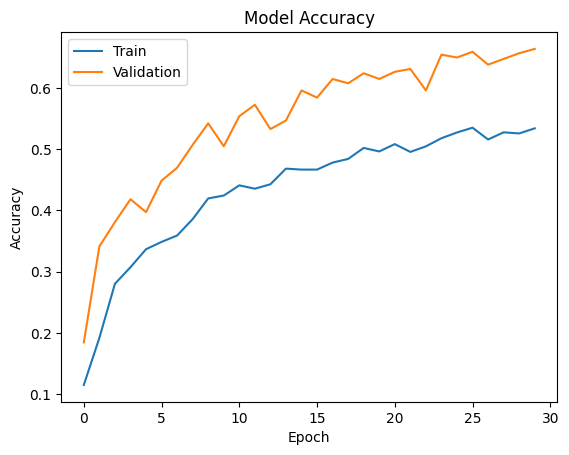

In [21]:
# Model Evaluation:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The model's accuracy is pretty good having good performance on the train and validation data. From this, the model does not appear to be overfit.

In [22]:
accuracy = model.evaluate(x_test_normalized, y_test_encoded, verbose=2)


15/15 - 0s - loss: 1.0745 - accuracy: 0.6695 - 156ms/epoch - 10ms/step


In [23]:
# Here we would get the output as probablities for each category
y_pred=model.predict(x_test_normalized)

15/15 [==============================] - 0s 3ms/step


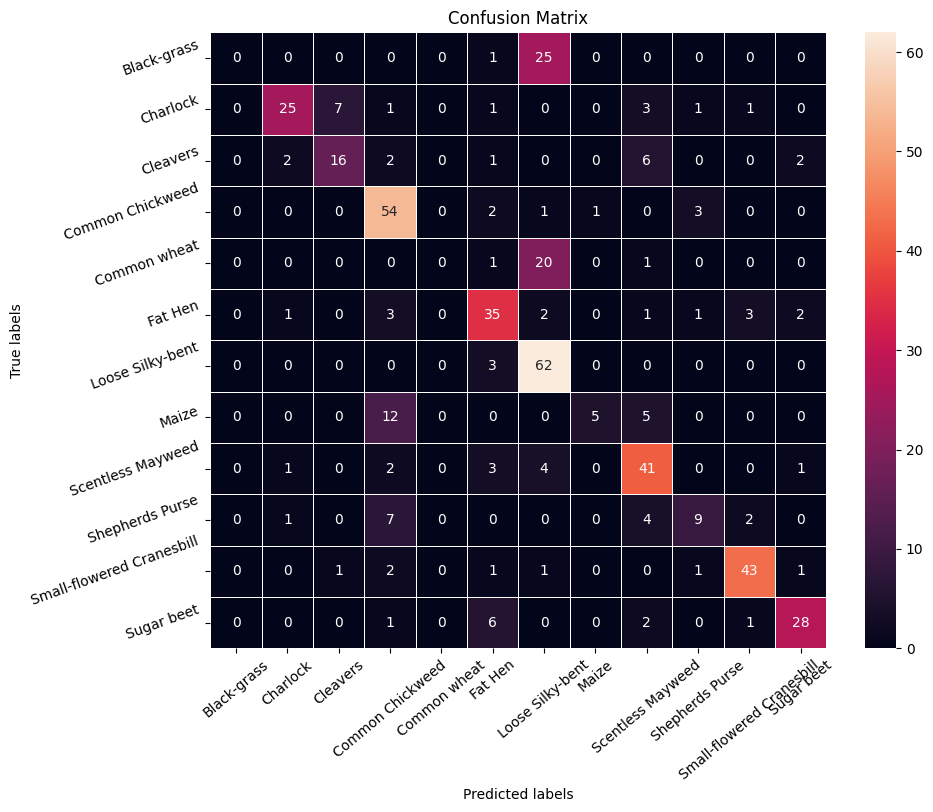

In [24]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

The model is having the most trouble with the Common Wheat flower, Maize, Scentless Mayweed, Sugar Beet, and Black-grass which were fully misrepresented.

In [25]:
# Plotting the classification report
cr = classification_report(y_test_arg, y_pred_arg, target_names=enc.classes_)
print(cr)

                           precision    recall  f1-score   support

              Black-grass       0.00      0.00      0.00        26
                 Charlock       0.83      0.64      0.72        39
                 Cleavers       0.67      0.55      0.60        29
         Common Chickweed       0.64      0.89      0.74        61
             Common wheat       0.00      0.00      0.00        22
                  Fat Hen       0.65      0.73      0.69        48
         Loose Silky-bent       0.54      0.95      0.69        65
                    Maize       0.83      0.23      0.36        22
        Scentless Mayweed       0.65      0.79      0.71        52
          Shepherds Purse       0.60      0.39      0.47        23
Small-flowered Cranesbill       0.86      0.86      0.86        50
               Sugar beet       0.82      0.74      0.78        38

                 accuracy                           0.67       475
                macro avg       0.59      0.56      0.55    

## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [26]:
# Code to monitor val_accuracy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

In [27]:
# Clearing backend and setting seed
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [28]:
# Create data with rotation_range to 20
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

In [29]:
# Intializing a sequential model
aug_model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
aug_model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
aug_model.add(MaxPooling2D((2, 2), padding = 'same'))

# Adding two similar convolution and max-polling layers with relu activation function, and batch normalization
aug_model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
aug_model.add(MaxPooling2D((2, 2), padding = 'same'))
aug_model.add(BatchNormalization())

aug_model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
aug_model.add(MaxPooling2D((2, 2), padding = 'same'))
aug_model.add(BatchNormalization())

# Flattening the output of the conv layer after max pooling to make it ready for creating dense connections
aug_model.add(Flatten())

# Adding a fully connected dense layer with 16 neurons
aug_model.add(Dense(16, activation='relu'))
# Adding dropout layer with dropout_rate = 0.3
aug_model.add(Dropout(0.3))

# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
aug_model.add(Dense(12, activation='softmax'))

# Using Adam Optimizer
opt = Adam()

# Compile model with optimizer, categorical_crossentropy as loss function, and prioritizing accuracy.
aug_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
aug_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 16, 16, 32)        128       
 Normalization)                                                  
                                                        

In [30]:
# Model fitting:
epochs = 30

batch_size = 64

aug_history = aug_model.fit(train_datagen.flow(x_train_normalized, y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=x_train_normalized.shape[0] // batch_size,
                                       validation_data=(x_val_normalized,y_val_encoded),
                                       verbose=1,callbacks=[learning_rate_reduction])

Epoch 1/30
60/60 [==============================] - 10s 126ms/step - loss: 2.3173 - accuracy: 0.2302 - val_loss: 2.4494 - val_accuracy: 0.1379 - lr: 0.0010
Epoch 2/30
60/60 [==============================] - 5s 77ms/step - loss: 1.9382 - accuracy: 0.3648 - val_loss: 2.5920 - val_accuracy: 0.1121 - lr: 0.0010
Epoch 3/30
60/60 [==============================] - 6s 93ms/step - loss: 1.7600 - accuracy: 0.4330 - val_loss: 2.7859 - val_accuracy: 0.1121 - lr: 0.0010
Epoch 4/30
60/60 [==============================] - ETA: 0s - loss: 1.5777 - accuracy: 0.4835
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
60/60 [==============================] - 6s 106ms/step - loss: 1.5777 - accuracy: 0.4835 - val_loss: 3.2521 - val_accuracy: 0.1098 - lr: 0.0010
Epoch 5/30
60/60 [==============================] - 5s 77ms/step - loss: 1.3804 - accuracy: 0.5451 - val_loss: 3.5140 - val_accuracy: 0.1075 - lr: 5.0000e-04
Epoch 6/30
60/60 [==============================] - 6s 93ms/step

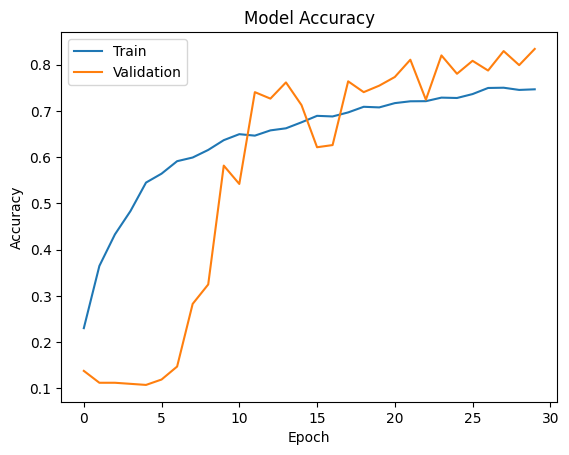

In [31]:
# Model Evaluation:
plt.plot(aug_history.history['accuracy'])
plt.plot(aug_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The performance of the model has improved by 600 basis pionts and the model does not appear to be overfit since it performs well on both the train and validation data set.

In [32]:
accuracy = aug_model.evaluate(x_test_normalized, y_test_encoded, verbose=2)


15/15 - 0s - loss: 0.6261 - accuracy: 0.8021 - 154ms/epoch - 10ms/step


In [33]:
# Here we would get the output as probablities for each category
aug_y_pred = aug_model.predict(x_test_normalized)

15/15 [==============================] - 0s 3ms/step


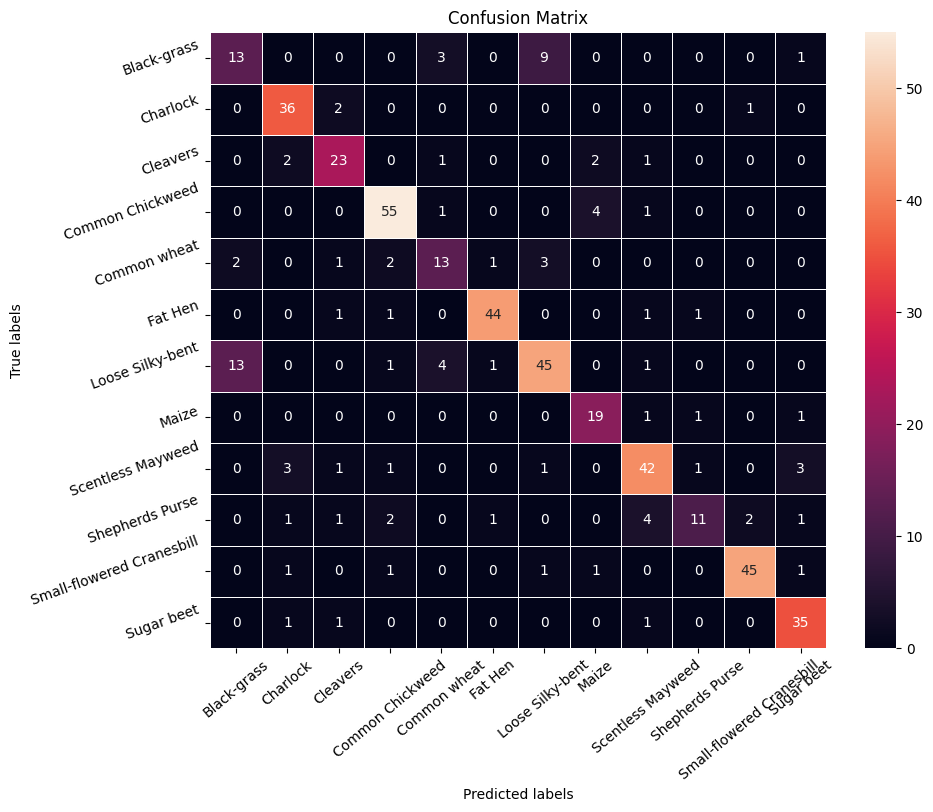

In [34]:
# Obtaining the categorical values from y_test_encoded and y_pred
aug_y_pred_arg = np.argmax(aug_y_pred,axis=1)
y_test_arg = np.argmax(y_test_encoded, axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg, aug_y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

The first model had the most trouble with the Common Wheat flower, Maize, Scentless Mayweed, Sugar Beet, and Black-grass which were fully misrepresented. Now those errors have been improved upon and the performance of the model is much better across all flower types.

In [35]:
# Plotting the classification report
cr = classification_report(y_test_arg, aug_y_pred_arg, target_names=enc.classes_)
print(cr)

                           precision    recall  f1-score   support

              Black-grass       0.46      0.50      0.48        26
                 Charlock       0.82      0.92      0.87        39
                 Cleavers       0.77      0.79      0.78        29
         Common Chickweed       0.87      0.90      0.89        61
             Common wheat       0.59      0.59      0.59        22
                  Fat Hen       0.94      0.92      0.93        48
         Loose Silky-bent       0.76      0.69      0.73        65
                    Maize       0.73      0.86      0.79        22
        Scentless Mayweed       0.81      0.81      0.81        52
          Shepherds Purse       0.79      0.48      0.59        23
Small-flowered Cranesbill       0.94      0.90      0.92        50
               Sugar beet       0.83      0.92      0.88        38

                 accuracy                           0.80       475
                macro avg       0.78      0.77      0.77    

## Final Model

Comment on the final model you have selected and use the same in the below code to visualize the image.

**Selected model:**
We will utilize the augmented model since it performs significantly better across the board, has a higher overall accuracy and is not overfit.

### Visualizing the prediction

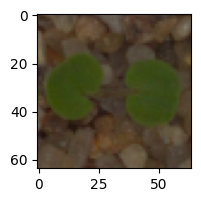

1/1 [==============================] - 0s 96ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


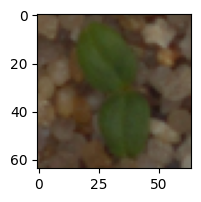

1/1 [==============================] - 0s 19ms/step
Predicted Label ['Cleavers']
True Label Cleavers


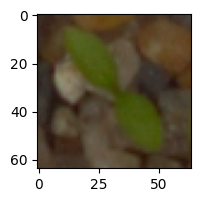

1/1 [==============================] - 0s 17ms/step
Predicted Label ['Common Chickweed']
True Label Common Chickweed


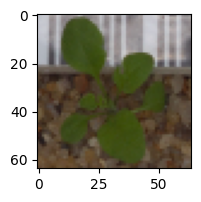

1/1 [==============================] - 0s 17ms/step
Predicted Label ['Shepherds Purse']
True Label Shepherds Purse


In [36]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(x_test[2])
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(aug_model.predict((x_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(x_test[33])
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(aug_model.predict((x_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(x_test[59],)
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(aug_model.predict((x_test_normalized[59].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[59])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(x_test[36])
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(aug_model.predict((x_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])                                              # using inverse_transform() to get the output label from the output vector

## Actionable Insights and Business Recommendations

### Conclusion:

In [37]:
pd.DataFrame({'Models':['Base CNN Model','CNN Model with Data Augmentation'],'Test Accuracy':['70.11%','76.84%']})

,Models,Test Accuracy
0,Base CNN Model,70.11%
1,CNN Model with Data Augmentation,76.84%


* We can observe from the prevoius results that our Base Convolutional Neural Network (CNN) was outperformed by our CNN with data augmentation.
* The augmented CNN outperformed the base CNN by 673 basis points, a considerable increase.
* Data augmentation really helped in this case since there where some weed types that the original CNN was not recognizing correctly at all.

### Acctionable Insights

* It might be worth training these models with the original resolution since there is little information available to distinguish between weeds it could be very usefull not to remove information.
* Black Grass, Common Wheat, and Loose Silky-bent continue to be problematic weeds so it might be good to gather some more images of those specific weeds.
* The Common Chickweed and the Fat Hen had the highest F1 scores, implying that they were the easiest for the model to guess.

_____

In [38]:
%%shell
jupyter nbconvert --to html "/content/drive/MyDrive/UT AI Course/Module 6 - Computer Vision/Project/High_Code_Plant_Seedling_Classification.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/UT AI Course/Module 6 - Computer Vision/Project/High_Code_Plant_Seedling_Classification.ipynb to html
[NbConvertApp] Writing 2073662 bytes to /content/drive/MyDrive/UT AI Course/Module 6 - Computer Vision/Project/High_Code_Plant_Seedling_Classification.html
